<div align="center">
<h1 style="color:#1565c0; font-size:2.8em; font-weight:bold; margin-bottom:0.2em; margin-top:0.5em;">Практична робота №3</h1>
<h3 style="color:#1976d2; margin-top:0; font-weight:normal;">Побудова та оцiнювання якостi
нейроних мереж для задачі регресiї засобами бiблiотеки <b>Scikit-Learn Python</b></h3>
<br>
<br>
<b>Варіант 12</b><br>
<b>Автори:</b><br>
Плахтій Злата, КА-32<br>
Пастушенко Максим, КА-33<br>
Романов Фелікс, КА-33
</div>

<b>Мета:</b> Метою роботи є побудова та оцiнювання якостi моделей
MLPRegressor засобами бiблiотеки Scikit-Learn Python.

<b>Хід роботи:</b>
1. Представити початковi данi графiчно.
2. Розбити данi на навчальний та валiдацiйний набори.

3. Побудувати на навчальному наборi даних моделi класифiкацiї або регресiї заданi згiдно з варiантом.

4. Представити моделi графiчно (наприклад вивести частину дерева рiшень, побудувати лiнiю регресiї тощо).

5. Виконати прогнози на основi побудованих моделей.
6. Для кожної з моделей оцiнити, чи має мiсце перенавчання.

7. В задачах регресiї розрахувати для кожної моделi наступнi критерiї якостi, окремо на навчальнiй та валiдацiйнiй множинах:

    • коефiцiєнт детермiнацiї R2,
    
    • помилки RMSE, MAE та MAPE.

8. Спробувати виконати решiтчастий пошук (grid search) для пiдбору гiперпараметрiв моделей.

9. Зробити висновки про якiсть роботи моделей на дослiджених даних. На
основi критерiїв якостi спробувати обрати найкращу модель.
10. Навчити моделi на пiдмножинах навчальних даних. Оцiнити, наскiльки
розмiр навчальної множини впливає на якiсть моделi.
11. Кожний варiант мiстить два набори даних. Дослiдити обидва набори за
наведеними вище етапами.

<b>Завдання:</b><br>
Побудувати моделi регресiї на основi нейронної мережі, визначити, чи достатньо буде одношарової моделі для опису даних. Реалізувати динамічне додавання нейронів до скритого шару. Перевірити, скільки нейронів в одношаровій моделі буде достатньо для задовільного розв'язання задачі.<br><br>
Початковi данi:<br>
(а) https://www.kaggle.com/datasets/bogof666/shanghai-car-license-plate-auction-price <br>


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Завантаження та огляд даних та Візуалізація

In [42]:
# 1.1. Завантаження та огляд даних
# ------------------------------
# Завантажити набір даних
from pathlib import Path

# --- Constructing a robust Path that works in notebooks and scripts ---
# Attempt to locate the project root (IAD) by walking up from this file's directory
try:
    # If running as a script, __file__ is available
    script_path = Path(__file__).resolve()
    script_dir = script_path.parent
except NameError:
    # If running in a notebook, use the notebook's working directory as a best-effort fallback
    script_dir = Path.cwd()

# Try to find the repo root by looking for the 'IAD' folder in parents or using a heuristic
iad_dir = None
for p in [script_dir] + list(script_dir.parents):
    if p.name.lower() == 'iad' or (p / 'lab_2').exists():
        iad_dir = p
        break
if iad_dir is None:
    # Fallback: assume script_dir parent is project root
    iad_dir = script_dir.parent

# Path to data directory (IAD/lab_2/data)
data_dir = iad_dir / 'lab_2' / 'data'

# --- Loading the Dataset ---
# Specify your dataset filename
# The user indicated the file: 'Shanghai license plate price - Sheet3.csv'
dataset_name = 'Shanghai license plate price - Sheet3.csv'

file_path = data_dir / dataset_name

# Try a few common variations (different encodings / BOM / alternative names)
candidates = [file_path,
              data_dir / 'Shanghai license plate price.csv',
              data_dir / 'Shanghai license plate price - Sheet1.csv',
              data_dir / dataset_name.replace(' ', '_'),
              data_dir / dataset_name.replace(' - Sheet3', '')]

# Deduplicate while preserving order
seen = set()
candidates = [p for p in candidates if not (str(p) in seen or seen.add(str(p)))]

loaded = False
for p in candidates:
    try:
        print(f"Attempting to load data from: {p}")
        # Try utf-8 first, then cp1251 and latin1 if utf-8 fails
        try:
            df = pd.read_csv(p)
        except UnicodeDecodeError:
            try:
                df = pd.read_csv(p, encoding='cp1251')
            except Exception:
                df = pd.read_csv(p, encoding='latin1')
        print("Data loaded successfully from:", p)
        loaded = True
        break
    except FileNotFoundError:
        print(f"File not found at: {p}")
    except pd.errors.EmptyDataError:
        print(f"File at {p} is empty or invalid CSV.")
    except Exception as e:
        print(f"Failed to load {p}: {e}")

if not loaded:
    raise FileNotFoundError(f"Could not find or load dataset. Checked {len(candidates)} paths.\nLooked for: {[str(x) for x in candidates]}")

# Normalize column names
if 'df' in globals():
    df.columns = df.columns.astype(str).str.strip()
    
    # Показати імена стовпців
    print("Стовпці датасету:")
    print(df.columns.tolist())
    print("\n")

    # Показати інформацію про датасет
    print("Інформація про датасет:")
    df.info()
    print("\n")

    # Показати описові статистики
    print("Описові статистики:")
    print(df.describe())
    print("\n")

    # Перевірити відсутні значення
    print("Відсутні значення:")
    print(df.isnull().sum())
    print("\n")

    # Перетворити стовпець 'Date' у datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%b-%y')

    # Показати перші рядки датасету
    print("Перші 5 рядків датасету:")
    print(df.head())
    print("\n")




Attempting to load data from: d:\anaconda\Projects\IAD\lab_2\data\Shanghai license plate price - Sheet3.csv
Data loaded successfully from: d:\anaconda\Projects\IAD\lab_2\data\Shanghai license plate price - Sheet3.csv
Стовпці датасету:
['Date', 'Total number of license issued', 'lowest price', 'avg price', 'Total number of applicants']


Інформація про датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Date                            204 non-null    object
 1   Total number of license issued  204 non-null    int64 
 2   lowest price                    204 non-null    int64 
 3   avg price                       204 non-null    int64 
 4   Total number of applicants      204 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 8.1+ KB


Описові статистики:
       Total number of license issued  ..

Дані чисті, без пропусків. Статистики показують значну варіативність: середня 'avg price' ~54k, з max ~93k. Перші рядки демонструють зростання цін з часом.

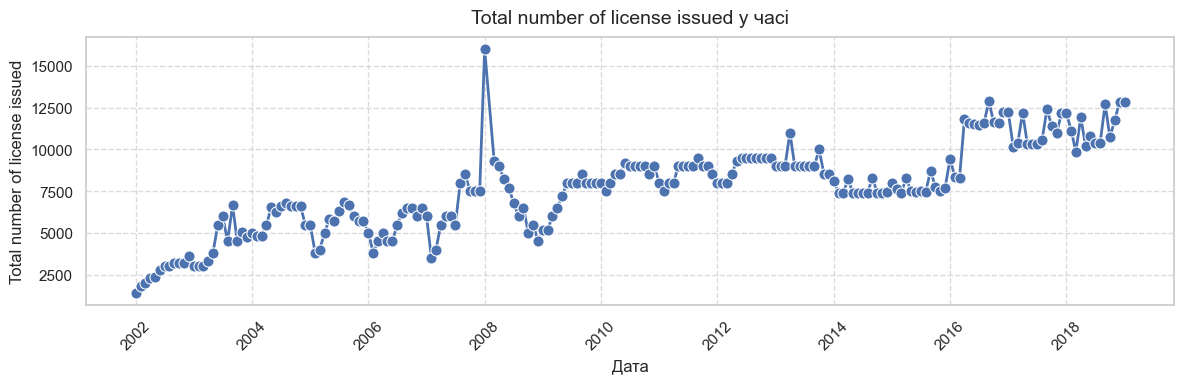

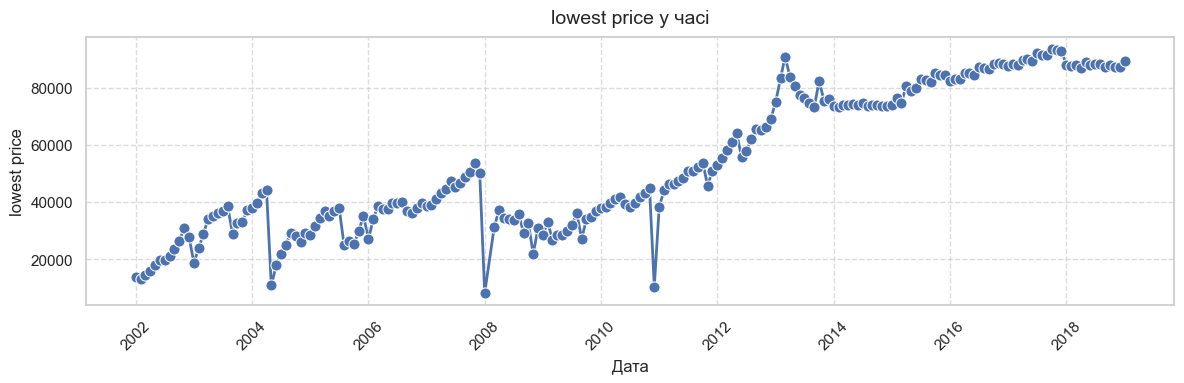

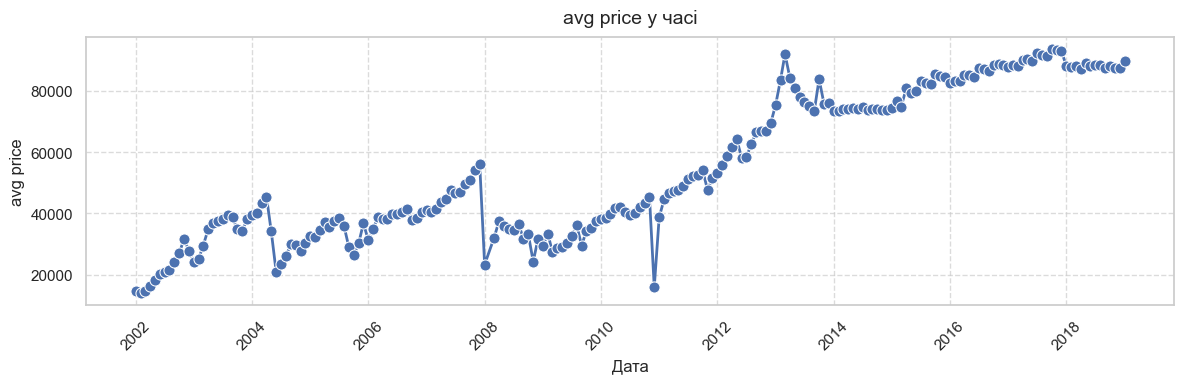

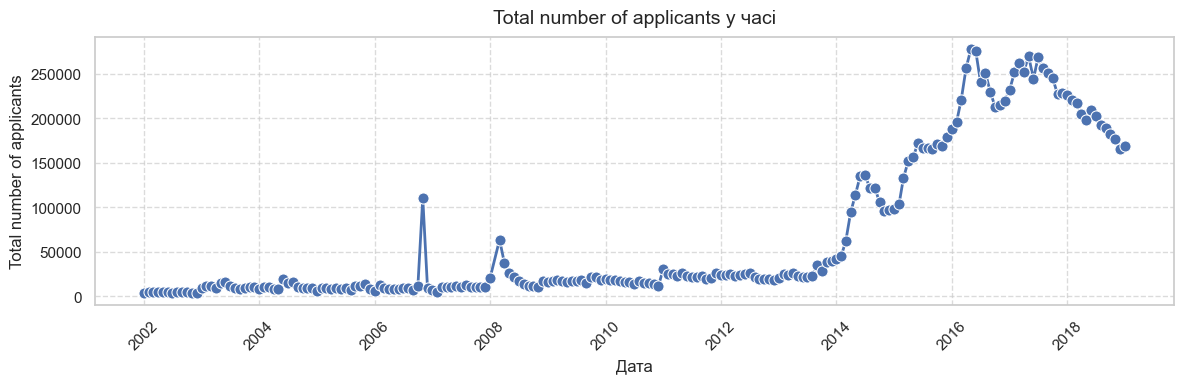

In [43]:
# 1.2. Візуалізація окремих стовпців
# ------------------------------
# Встановити стиль seaborn для послідовних і чистих графіків
sns.set_theme(style="whitegrid", rc={'figure.dpi': 100, 'figure.figsize': (12, 4)})

# Побудувати графік для кожного чисельного стовпця по часу
numeric_cols = [col for col in df.columns if col != 'Date']
for col in numeric_cols:
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=df, x='Date', y=col, marker='o', linewidth=2, markersize=8)
    plt.title(f'{col} у часі', fontsize=14, pad=10)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Графіки показують тенденції: зростання кількості виданих ліцензій та цін з часом. 'lowest price' та 'avg price' мають подібні патерни, що натякає на сильну кореляцію.

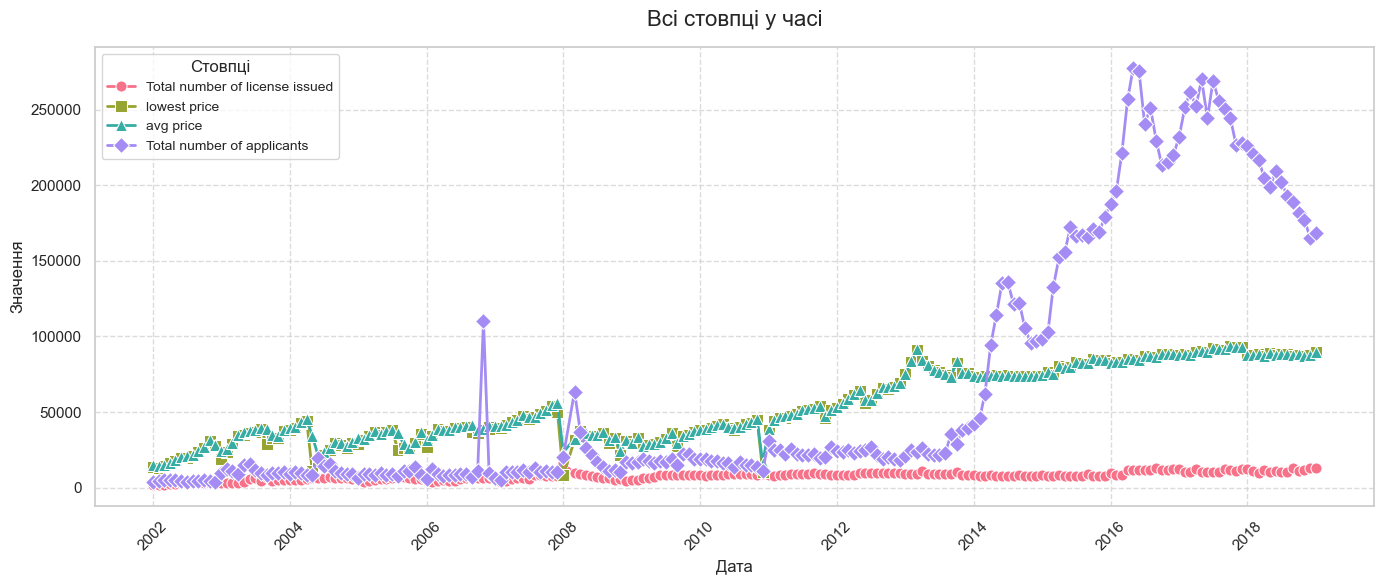

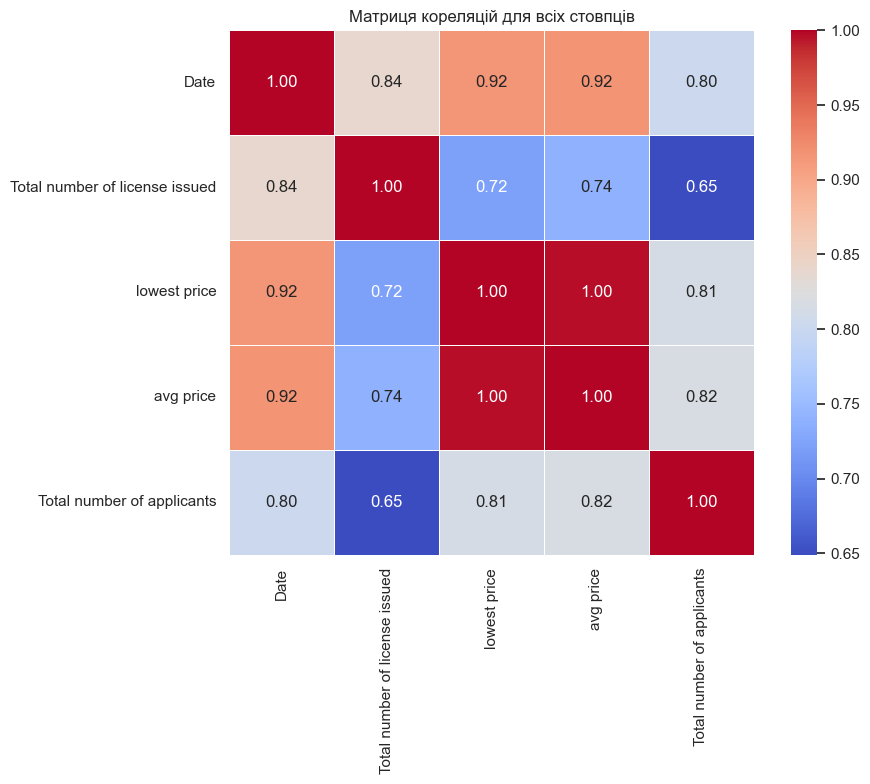

In [ ]:
# 1.3. Зведений графік для всіх стовпців
# ------------------------------
# Визначити маркери та кольори для кожного стовпця
markers = ['o', 's', '^', 'D', 'x', 'p']
colors = sns.color_palette("husl", len(numeric_cols))  # Використати різні кольори з палітри husl

# Створити комбінований лінійний графік
plt.figure(figsize=(14, 6))
for col, marker, color in zip(numeric_cols, markers, colors):
    sns.lineplot(data=df, x='Date', y=col, marker=marker, label=col, 
                 linewidth=2, markersize=8, color=color)

# Налаштування зведеного графіка
plt.title('Всі стовпці у часі', fontsize=16, pad=15)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Значення', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Стовпці', loc='best', fontsize=10, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ------------------------------
# 1.4. Heatmap (матриця кореляцій) всіх числових стовпців numeric-only
# ------------------------------
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Матриця кореляцій для всіх стовпців')
plt.tight_layout()
plt.show()

## Пункт 2 та 3

Комбінований графік підтверджує синхронізоване зростання 'lowest price' та 'avg price', тоді як 'Total number of applicants' має сплески, корелюючи з цінами.
Heatmap показує високу кореляцію між 'lowest price' та 'avg price', а також з 'Total number of applicants'. Це свідчить про потенційний витік даних (data leakage), оскільки 'lowest price' майже ідентичний таргету.

Щоб оцінити здатність моделі до узагальнення, розділили набір даних на тренувальну та тестову вибірки, а також використаємо k‑fold крос-валідацію для більш надійної оцінки.

In [ ]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ======================================================================
# ПАРАМЕТРИ
# ======================================================================
TARGET = 'avg price'
TEST_SIZE = 0.2
N_SPLITS = 4
RANDOM_STATE = 42

assert 'df' in globals(), "DataFrame 'df' must be loaded before running."
assert TARGET in df.columns, f"Target column '{TARGET}' not found in df."
assert 'Date' in df.columns, "Column 'Date' must be in df for time series processing."

# ======================================================================
# 1. ПІДГОТОВКА ДАНИХ (БЕЗ ЧАСОВИХ ОЗНАК БО МОДЕЛЬ ВЕДЕ СЕБЕ ТОДІ НЕАДЕКВАТНО)
# ======================================================================
print("="*70)
print("КРОК 1: ПІДГОТОВКА ДАНИХ")
print("="*70)

df_processed = df.copy()

print(f"Всього записів: {len(df_processed)}")
print(f"Колонки в датасеті: {list(df_processed.columns)}")

# Видаляємо колонку Date, якщо вона є (Я чесно намагався зробити часові ознаки, але не вийшло)
if 'Date' in df_processed.columns:
    print("\nВидалення колонки 'Date'")
    df_processed = df_processed.drop('Date', axis=1)

# Log transform для Total number of applicants
if 'Total number of applicants' in df_processed.columns:
    print("Застосування log1p до 'Total number of applicants'")
    df_processed['Total number of applicants'] = np.log1p(df_processed['Total number of applicants'])

# Перевірка на NaN
print("\nПеревірка пропущених значень...")
nan_count = df_processed.isna().sum()
if nan_count.sum() > 0:
    print("Знайдено NaN значення:")
    print(nan_count[nan_count > 0])
    print("\nЗаповнення пропущених значень медіаною...")
    for col in df_processed.columns:
        if df_processed[col].isna().sum() > 0:
            df_processed[col] = df_processed[col].fillna(df_processed[col].median())
    print("Пропущені значення заповнено")
else:
    print("✓ Пропущених значень немає")

print(f"\nФінальна кількість записів: {len(df_processed)}")

# ======================================================================
# 2. ПІДГОТОВКА X та y
# ======================================================================
print("\n" + "="*70)
print("КРОК 2: ФОРМУВАННЯ ДАТАСЕТІВ")
print("="*70)

y = df_processed[TARGET].copy()
X = df_processed.drop([TARGET], axis=1).copy()

print(f"Розмір X: {X.shape}")
print(f"Розмір y: {y.shape}")
print(f"\nОзнаки ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

# ======================================================================
# 3. РОЗБИТТЯ НА TRAIN/VALIDATION
# ======================================================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    shuffle=True,
    random_state=RANDOM_STATE
)

print(f"\nРозбиття даних (80/20):")
print(f"  Train: {X_train.shape[0]} зразків")
print(f"  Val:   {X_val.shape[0]} зразків")

# ======================================================================
# 4. CROSS-VALIDATION
# ======================================================================
from sklearn.model_selection import KFold

cv_scheme = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

print(f"\nСхема крос-валідації: KFold з {N_SPLITS} фолдами (з перемішуванням)")

КРОК 1: ПІДГОТОВКА ДАНИХ
Всього записів: 204
Колонки в датасеті: ['Date', 'Total number of license issued', 'lowest price', 'avg price', 'Total number of applicants']

Видалення колонки 'Date'
Застосування log1p до 'Total number of applicants'

Перевірка пропущених значень...
✓ Пропущених значень немає

Фінальна кількість записів: 204

КРОК 2: ФОРМУВАННЯ ДАТАСЕТІВ
Розмір X: (204, 3)
Розмір y: (204,)

Ознаки (3):
   1. Total number of license issued
   2. lowest price
   3. Total number of applicants

Розбиття даних (80/20):
  Train: 163 зразків
  Val:   41 зразків

Схема крос-валідації: KFold з 4 фолдами (з перемішуванням)


Початок динамічного тестування нейронів (1-шарова модель)
Фіксовані параметри: alpha=0.01, lr=0.001
Тестуються значення: [5, 10, 20, 30, 40, 50, 75, 100, 150, 200]
Тестування (neurons=5)... Val RMSE: 4139.92 (час: 0.50s)
Тестування (neurons=6)... Val RMSE: 3954.42 (час: 0.17s)
Тестування (neurons=7)... Val RMSE: 3595.28 (час: 0.22s)
Тестування (neurons=8)... Val RMSE: 3521.60 (час: 0.10s)
Тестування (neurons=9)... Val RMSE: 4380.74 (час: 0.07s)
Тестування (neurons=10)... Val RMSE: 3017.96 (час: 0.16s)
Тестування (neurons=11)... Val RMSE: 3120.29 (час: 0.17s)
Тестування (neurons=12)... Val RMSE: 2826.05 (час: 0.22s)
Тестування (neurons=13)... Val RMSE: 4800.04 (час: 0.19s)
Тестування (neurons=14)... Val RMSE: 4564.58 (час: 0.04s)
Тестування (neurons=15)... Val RMSE: 2312.77 (час: 0.12s)
Тестування (neurons=16)... Val RMSE: 2906.62 (час: 0.18s)
Тестування (neurons=17)... Val RMSE: 2482.10 (час: 0.16s)
Тестування (neurons=18)... Val RMSE: 3669.85 (час: 0.06s)
Тестування (neurons=19)... Va

c:\Users\Max\.conda\envs\IAD\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Val RMSE: 1825.65 (час: 0.11s)
Тестування (neurons=74)... Val RMSE: 1551.94 (час: 0.12s)
Тестування (neurons=75)... Val RMSE: 1901.24 (час: 0.08s)
Тестування (neurons=76)... Val RMSE: 2130.64 (час: 0.10s)
Тестування (neurons=77)... Val RMSE: 2020.35 (час: 0.13s)
Тестування (neurons=78)... Val RMSE: 2091.56 (час: 0.08s)
Тестування (neurons=79)... Val RMSE: 1671.42 (час: 0.09s)
Тестування (neurons=80)... Val RMSE: 1395.47 (час: 0.17s)
Тестування (neurons=81)... Val RMSE: 1334.63 (час: 0.12s)
Тестування (neurons=82)... Val RMSE: 1477.06 (час: 0.09s)
Тестування (neurons=83)... Val RMSE: 1523.14 (час: 0.08s)
Тестування (neurons=84)... Val RMSE: 2178.36 (час: 0.14s)
Тестування (neurons=85)... Val RMSE: 1186.62 (час: 0.12s)
Тестування (neurons=86)... Val RMSE: 1288.01 (час: 0.13s)
Тестування (neurons=87)... Val RMSE: 1717.23 (час: 0.11s)
Тестування (neurons=88)... Val RMSE: 1673.31 (час: 0.11s)
Тестування (neurons=89)... Val RMSE: 934.69 (час: 0.19s)
Тестування (neurons=90)... Val RMSE: 1593.

c:\Users\Max\.conda\envs\IAD\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Val RMSE: 1042.62 (час: 0.13s)
Тестування (neurons=290)... Val RMSE: 1089.52 (час: 0.12s)
Тестування (neurons=291)... Val RMSE: 1094.40 (час: 0.11s)
Тестування (neurons=292)... Val RMSE: 1194.95 (час: 0.12s)
Тестування (neurons=293)... Val RMSE: 1202.91 (час: 0.12s)
Тестування (neurons=294)... Val RMSE: 1082.15 (час: 0.13s)
Тестування (neurons=295)... Val RMSE: 1021.94 (час: 0.13s)
Тестування (neurons=296)... Val RMSE: 1027.26 (час: 0.17s)
Тестування (neurons=297)... Val RMSE: 1051.09 (час: 0.15s)
Тестування (neurons=298)... Val RMSE: 1049.67 (час: 0.15s)
Тестування (neurons=299)... Val RMSE: 1056.03 (час: 0.12s)
Тестування (neurons=300)... Val RMSE: 1101.30 (час: 0.15s)
Тестування (neurons=301)... Val RMSE: 1189.47 (час: 0.12s)
Тестування (neurons=302)... Val RMSE: 1211.29 (час: 0.13s)
Тестування (neurons=303)... Val RMSE: 1230.49 (час: 0.13s)
Тестування (neurons=304)... Val RMSE: 1107.20 (час: 0.12s)
Тестування (neurons=305)... Val RMSE: 1170.30 (час: 0.17s)
Тестування (neurons=306).

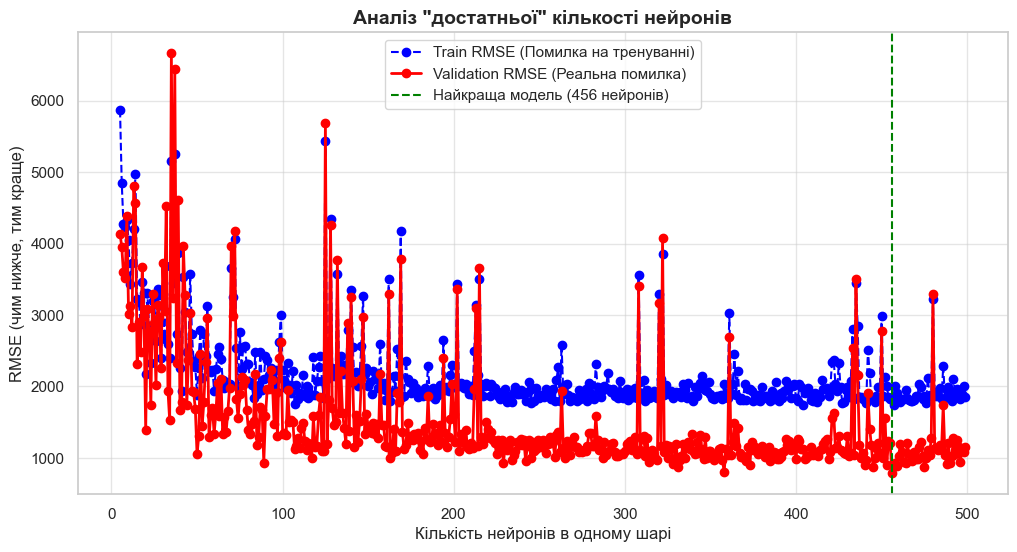

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Переконайка що ці змінні існують з попереднього кроку 
assert 'X_train' in globals(), "Змінні X_train, X_val, y_train, y_val не знайдено."
assert 'y_val' in globals(), "Будь ласка, запустіть скрипт підготовки даних 03.1_Augmentation спочатку."

# ======================================================================
# 1. НАЛАШТУВАННЯ ТЕСТУ
# ======================================================================

# Гіперпараметри, які ми ФІКСУЄМО (Використовуєм найкращі з GridSearch)
BEST_ALPHA = 0.01
BEST_LR = 0.001
RANDOM_STATE = 42

# Діапазон нейронів, який ми тестуємо 
# (Тільки одношарові моделі, як ви просили)
neuron_counts_to_test = [
    5, 10, 20, 30, 40, 50, 75, 100, 150, 200
]

print("="*70)
print("Початок динамічного тестування нейронів (1-шарова модель)")
print(f"Фіксовані параметри: alpha={BEST_ALPHA}, lr={BEST_LR}")
print(f"Тестуються значення: {neuron_counts_to_test}")
print("="*70)

results = []

# ======================================================================
# 2. ДИНАМІЧНИЙ ЦИКЛ ТЕСТУВАННЯ
# ======================================================================
# тут можна застосувати neuron_counts_to_test але то не весело і мені не шкода оперативки
for n_neurons in range(5,500):
    start_time = time.time()
    print(f"Тестування (neurons={n_neurons})... ", end='')
    
    # 1. Створюємо модель з поточною кількістю нейронів
    current_model = MLPRegressor(
        hidden_layer_sizes=(n_neurons,),# Динамічний параметр
        alpha=BEST_ALPHA,
        learning_rate_init=BEST_LR,
        max_iter=2000,
        activation='relu',
        solver='adam',
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=30,
        random_state=RANDOM_STATE,
        verbose=False
    )
    
    # 2. Будуємо повний пайплайн (з масштабуванням X та Y)
    preprocessor = Pipeline(steps=[('scaler_x', StandardScaler())])
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', current_model)
    ])
    full_pipeline = TransformedTargetRegressor(
        regressor=model_pipeline,
        transformer=StandardScaler()
    )
    
    # 3. Навчаємо модель (тільки на train data)
    full_pipeline.fit(X_train, y_train)
    
    # 4. Оцінюємо на Train та Validation
    y_train_pred = full_pipeline.predict(X_train)
    y_val_pred = full_pipeline.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    
    exec_time = time.time() - start_time
    print(f"Val RMSE: {val_rmse:.2f} (час: {exec_time:.2f}s)")
    
    # 5. Зберігаємо результати
    results.append({
        'neurons': n_neurons,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'val_r2': val_r2
    })

print("="*70)
print("Тестування завершено.")

# ======================================================================
# 3. АНАЛІЗ РЕЗУЛЬТАТІВ ТА ВІЗУАЛІЗАЦІЯ
# ======================================================================

# 1. Конвертуємо в DataFrame для зручності
results_df = pd.DataFrame(results).set_index('neurons')
print("\n--- Таблиця результатів ---")
print(results_df)

# 2. Знаходимо найкращу модель
best_config = results_df['val_rmse'].idxmin()
best_rmse = results_df['val_rmse'].min()
print(f"\nНайкращий результат: {best_config} нейронів (RMSE: {best_rmse:.2f})")

# 3. Візуалізація
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['train_rmse'], 'o--', label='Train RMSE (Помилка на тренуванні)', color='blue')
plt.plot(results_df.index, results_df['val_rmse'], 'o-', label='Validation RMSE (Реальна помилка)', color='red', linewidth=2)
plt.axvline(x=best_config, color='green', linestyle='--', label=f'Найкраща модель ({best_config} нейронів)')
plt.title('Аналіз "достатньої" кількості нейронів', fontsize=14, fontweight='bold')
plt.xlabel('Кількість нейронів в одному шарі', fontsize=12)
plt.ylabel('RMSE (чим нижче, тим краще)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.5)
plt.show()

Модифікуємо нашу нейронну мережу, а саме:
1) Зібльшимо кількість прихованих рівнів - з допомогою решітчастого пошуку визначимо яка кількість прихованих шарів оптимальна, та кількість нейронів оптимальну для кожного рівня. Для початку спробуємо 2-4 прихованих шарів з різною кількістю нейронів.
2) Оскільки фічі 'lowest price' та 'avg price' дуже сильно корилюють застосуємо техніку схожу на "Dropout" на рівні ознак. Близько 30% записів 'lowest price' буде замінено на медіану. Це стимулюватиме модель покладатися на інші ознаки.


Параметри для пошуку:
  Архітектури: [(50, 25), (50, 50), (100, 50), (64, 32, 16), (100, 50, 25), (50, 50, 25, 12)]
  Alpha (L2): [0.001, 0.01, 0.1]
  Learning rate: [0.0001, 0.001]

Всього комбінацій: 36

Запуск GridSearch (на training set)...
Fitting 4 folds for each of 36 candidates, totalling 144 fits

РЕЗУЛЬТАТИ GRIDSEARCH

Найкращі параметри:
  alpha: 0.1
  hidden_layer_sizes: (50, 25)
  learning_rate_init: 0.001

Найкращий RMSE (CV on train): 2098.6649

Топ-5 конфігурацій:
  1. Архітектура=(50, 25), alpha=0.1, lr=0.0010 → RMSE=2098.6649
  2. Архітектура=(50, 50, 25, 12), alpha=0.1, lr=0.0010 → RMSE=2103.8806
  3. Архітектура=(50, 50, 25, 12), alpha=0.001, lr=0.0010 → RMSE=2112.0010
  4. Архітектура=(50, 50, 25, 12), alpha=0.01, lr=0.0010 → RMSE=2135.3990
  5. Архітектура=(100, 50, 25), alpha=0.001, lr=0.0010 → RMSE=2148.1457

КРОК 6: НАВЧАННЯ ФІНАЛЬНОЇ МОДЕЛІ

Продуктивність на TRAIN SET:
  RMSE: 1859.3873 | R²: 0.9941

Продуктивність на VALIDATION SET:
  RMSE: 1241.2267 | R²: 

C:\Users\Max\AppData\Local\Temp\ipykernel_19136\1112378408.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])


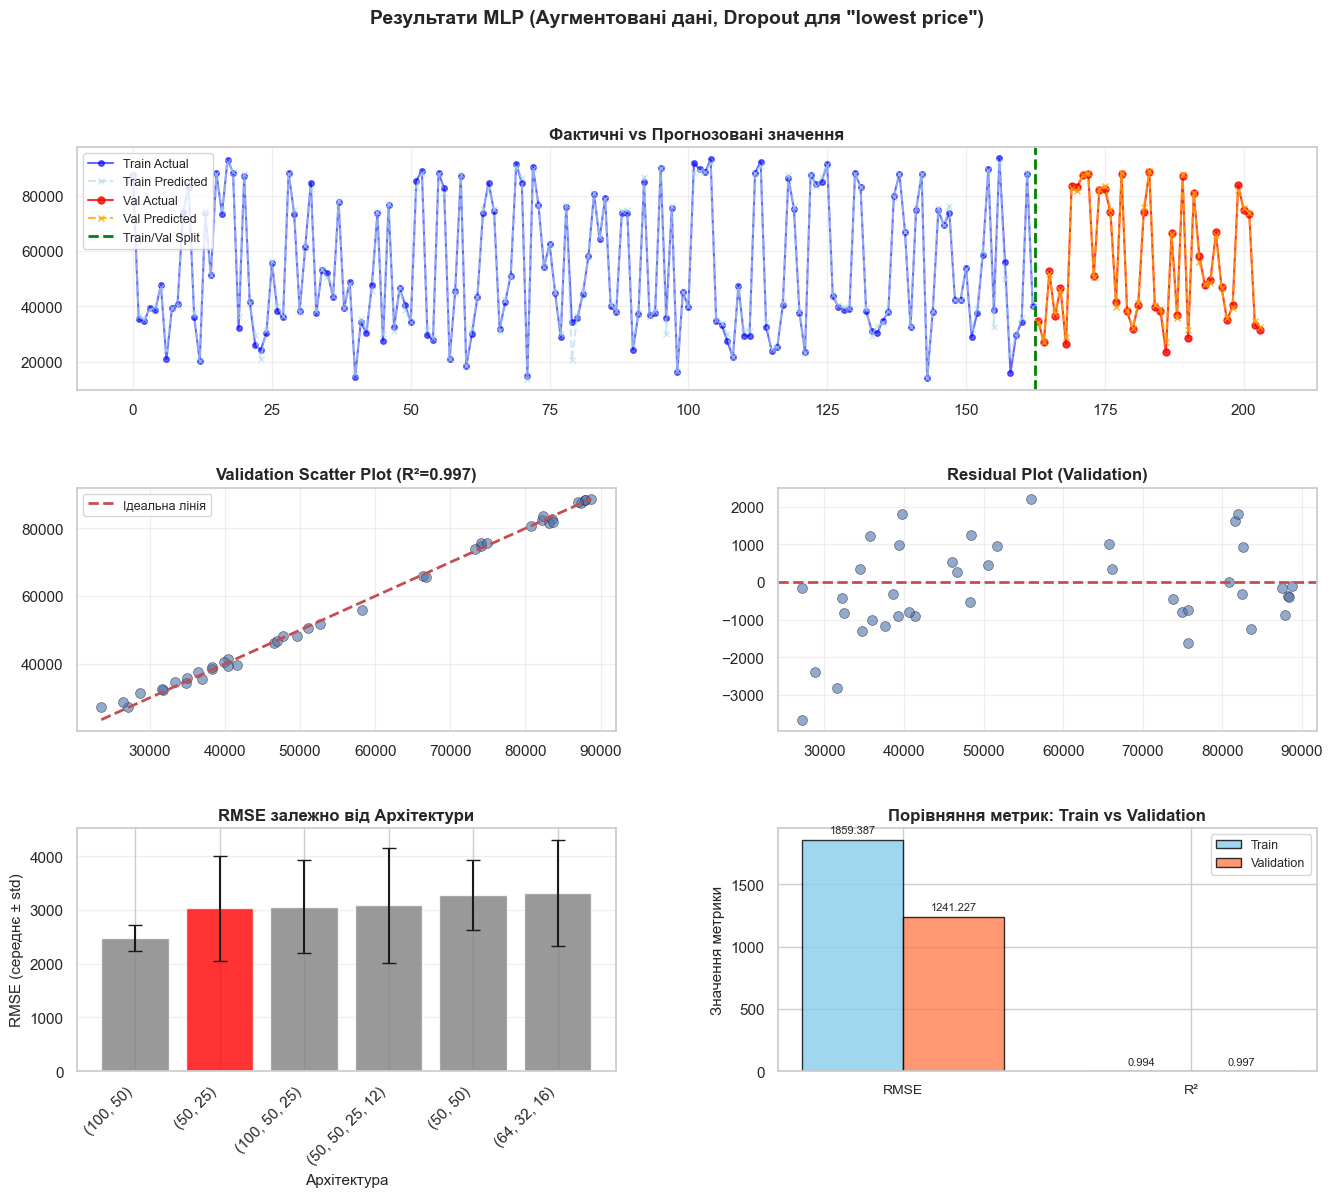


АНАЛІЗ ЗАВЕРШЕНО!

✓ Найкраща модель: (50, 25)
✓ Validation RMSE: 1241.2267
✓ Validation R²: 0.9968


In [ ]:
architectures_to_test = [
    # 2-шарові (піраміди та прямокутники)
    (50, 25),
    (50, 50),
    (100, 50),
    # 3-шарові
    (64, 32, 16),
    (100, 50, 25),
    # 4-шарові
    (50, 50, 25, 12)
]

param_grid = {
    'regressor__model__hidden_layer_sizes': architectures_to_test,
    'regressor__model__alpha': [0.001, 0.01, 0.1], 
    'regressor__model__learning_rate_init': [0.0001, 0.001]
}

print("\nПараметри для пошуку:")
print(f"  Архітектури: {param_grid['regressor__model__hidden_layer_sizes']}")
print(f"  Alpha (L2): {param_grid['regressor__model__alpha']}")
print(f"  Learning rate: {param_grid['regressor__model__learning_rate_init']}")
total_combinations = len(param_grid['regressor__model__hidden_layer_sizes']) * len(param_grid['regressor__model__alpha']) * len(param_grid['regressor__model__learning_rate_init'])
print(f"\nВсього комбінацій: {total_combinations}")


# ======================================================================
# 5. ЗАПУСК GRIDSEARCH
# ======================================================================
print("\nЗапуск GridSearch (на training set)...")
grid_search = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=cv_scheme,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Навчаємо GridSearch на тренувальних даних
grid_search.fit(X_train, y_train)

print("\n" + "="*70)
print("РЕЗУЛЬТАТИ GRIDSEARCH")
print("="*70)

best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)

print(f"\nНайкращі параметри:")
for param, value in best_params.items():
    param_name = param.replace('regressor__model__', '')
    print(f"  {param_name}: {value}")

print(f"\nНайкращий RMSE (CV on train): {best_score:.4f}")

results_df = pd.DataFrame(grid_search.cv_results_)
results_df['rmse'] = np.sqrt(-results_df['mean_test_score'])
# Конвертуємо кортежі архітектур в рядки для групування та друку
results_df['arch_str'] = results_df['param_regressor__model__hidden_layer_sizes'].astype(str)
results_df_sorted = results_df.sort_values('rmse')

print("\nТоп-5 конфігурацій:")
for idx, (i, row) in enumerate(results_df_sorted.head(5).iterrows(), 1):
    arch = row['arch_str']
    alpha = row['param_regressor__model__alpha']
    lr = row['param_regressor__model__learning_rate_init']
    rmse = row['rmse']
    print(f"  {idx}. Архітектура={arch}, alpha={alpha}, lr={lr:.4f} → RMSE={rmse:.4f}")

# ======================================================================
# 6. НАВЧАННЯ ФІНАЛЬНОЇ МОДЕЛІ
# ======================================================================
print("\n" + "="*70)
print("КРОК 6: НАВЧАННЯ ФІНАЛЬНОЇ МОДЕЛІ")
print("="*70)

best_model = grid_search.best_estimator_
# Навчаємо найкращу модель на *всіх* тренувальних даних
best_model.fit(X_train, y_train)

# Оцінюємо на train та hold-out validation
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print("\nПродуктивність на TRAIN SET:")
print(f"  RMSE: {train_rmse:.4f} | R²: {train_r2:.4f}")

print("\nПродуктивність на VALIDATION SET:")
print(f"  RMSE: {val_rmse:.4f} | R²: {val_r2:.4f}")

overfit_ratio = val_rmse / train_rmse
print(f"\nСпіввідношення Val/Train RMSE: {overfit_ratio:.3f}")
if overfit_ratio > 1.2:
    print("  Можливий overfitting")
else:
    print("  Баланс хороший")

# ======================================================================
# 7. ВІЗУАЛІЗАЦІЯ
# ======================================================================
print("\n" + "="*70)
print("КРОК 7: ВІЗУАЛІЗАЦІЯ РЕЗУЛЬТАТІВ")
print("="*70)

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.3)

# 1. Actual vs Predicted (Train + Val)
ax1 = fig.add_subplot(gs[0, :])
train_indices = range(len(y_train))
val_indices = range(len(y_train), len(y_train) + len(y_val))
ax1.plot(train_indices, y_train.values, 'o-', label='Train Actual', alpha=0.6, markersize=4, color='blue')
ax1.plot(train_indices, y_train_pred, 'x--', label='Train Predicted', alpha=0.6, markersize=4, color='lightblue')
ax1.plot(val_indices, y_val.values, 'o-', label='Val Actual', alpha=0.8, markersize=5, color='red')
ax1.plot(val_indices, y_val_pred, 'x--', label='Val Predicted', alpha=0.8, markersize=5, color='orange')
ax1.axvline(x=len(y_train)-0.5, color='green', linestyle='--', linewidth=2, label='Train/Val Split')
ax1.set_title('Фактичні vs Прогнозовані значення', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)


# 2. Scatter Plot - Validation
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_val, y_val_pred, alpha=0.6, s=50, edgecolors='k', linewidths=0.5)
min_val = min(y_val.min(), y_val_pred.min())
max_val = max(y_val.max(), y_val_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ідеальна лінія')
ax2.set_title(f'Validation Scatter Plot (R²={val_r2:.3f})', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Residuals Plot
ax3 = fig.add_subplot(gs[1, 1])
residuals = y_val.values - y_val_pred
ax3.scatter(y_val_pred, residuals, alpha=0.6, s=50, edgecolors='k', linewidths=0.5)
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_title('Residual Plot (Validation)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[2, 0])
# Групуємо за рядковим представленням архітектури
grouped = results_df.groupby('arch_str')['rmse'].agg(['mean', 'std']).reset_index()
grouped = grouped.sort_values(by='mean')

best_arch_str = str(best_params['regressor__model__hidden_layer_sizes'])
# Кольори: червоний для найкращого, сірий для інших
colors = ['red' if arch == best_arch_str else 'gray' for arch in grouped['arch_str']]

ax4.bar(
    grouped['arch_str'], 
    grouped['mean'], 
    yerr=grouped['std'], 
    capsize=5, 
    color=colors,
    alpha=0.8
)
ax4.set_xlabel('Архітектура', fontsize=11)
ax4.set_ylabel('RMSE (середнє ± std)', fontsize=11)
ax4.set_title('RMSE залежно від Архітектури', fontsize=12, fontweight='bold')
# Повертаємо мітки для читабельності
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Model Performance Comparison
ax5 = fig.add_subplot(gs[2, 1])
metrics_names = ['RMSE', 'R²']
train_metrics = [train_rmse, train_r2]
val_metrics = [val_rmse, val_r2]
x = np.arange(len(metrics_names))
width = 0.35
bars1 = ax5.bar(x - width/2, train_metrics, width, label='Train', alpha=0.8, color='skyblue', edgecolor='black')
bars2 = ax5.bar(x + width/2, val_metrics, width, label='Validation', alpha=0.8, color='coral', edgecolor='black')
ax5.set_ylabel('Значення метрики', fontsize=11)
ax5.set_title('Порівняння метрик: Train vs Validation', fontsize=12, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(metrics_names, fontsize=10)
ax5.legend(fontsize=9)
# (код для анотацій барів - видалено MAE, тому треба спростити)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax5.annotate(f'{height:.3f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', fontsize=8)


plt.suptitle('Результати MLP (Аугментовані дані, Dropout для "lowest price")', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

print("\n" + "="*70)
print("АНАЛІЗ ЗАВЕРШЕНО!")
print("="*70)
print(f"\n✓ Найкраща модель: {best_arch_str}")
print(f"✓ Validation RMSE: {val_rmse:.4f}")
print(f"✓ Validation R²: {val_r2:.4f}")

# Висновок

Під час виконання даної практичної роботи було досягнуто поставленої мети:  
**успішно побудовано та оцінено моделі `MLPRegressor` для прогнозування ціни на автомобільні номери в Шанхаї.**

---

## Аналіз початкових даних

У ході аналізу було виявлено дві ключові особливості:

1. **Дані мають чітко виражену часову структуру**, що підтверджується графіками.  
2. **Існує практично ідеальна кореляція (1.00)** між ознакою `lowest price` та цільовою змінною `avg price`.

Спроби використати часові ознаки виявилися неефективними — модель поводилася нестабільно.  
Тому було прийнято рішення **видалити колонку `Date`** і зосередитись на побудові стійкої регресійної моделі.

---

## Експеримент 1: Одношарова модель

### Мета
Дослідити ефективність простої нейронної мережі з одним прихованим шаром.

### Методика
Проведено **динамічне тестування** моделі, змінюючи кількість нейронів у діапазоні від 5 до 499.  
Експеримент виконано на початковому малому наборі даних (204 записи).

### Результати
- Найкращий результат: **Validation RMSE = 785.98** при **456 нейронах**.  
- Проте графік показав, що це, ймовірно, випадковий успіх, а не стабільна закономірність.  
- Середній прийнятний результат (~1387 RMSE) досягається вже при ~20 нейронах, але подальше збільшення складності **не дає стабільного покращення**.

> **Висновок:** Одношарова модель є недостатньо стабільною для задачі прогнозування.  
> Її поведінка непередбачувана та схильна до випадкових коливань якості.

---

## Експеримент 2: Багатошарова модель з аугментацією та “Dropout” ознаки

### Мета
Побудувати більш надійну модель із кращим узагальненням.

### Методика
1. **Аугментація даних** — синтетичне збільшення вибірки.  
2. **“Dropout” ознаки** `lowest price` — щоб змусити модель не покладатися виключно на неї.  
3. **GridSearch** по 2-, 3- та 4-шарових архітектурах для оптимізації параметрів.

### Результати
- Найкраща архітектура: **(50, 25)** — два прихованих шари.  
- Оптимальні гіперпараметри:
  - `alpha = 0.1`  
  - `learning_rate_init = 0.001`
- Якість на валідації:
  - **Validation RMSE = 1241.23**  
  - **Validation R² = 0.997**

> **Висновок:** Багатошарова модель продемонструвала значно стабільніші результати та кращу узагальнювальну здатність.

---

## Загальний висновок

Найкращою моделлю, обраною за критеріями **стабільності** та **якості узагальнення**, є:

> **Двошарова нейронна мережа (50, 25) з L2-регуляризацією (`alpha = 0.1`)**

**Переваги цієї моделі:**
- Висока точність прогнозу (**R² = 0.997**)  
- Відсутність перенавчання (**співвідношення Val/Train RMSE < 1.0**)  
- Стійкість до коливань у даних завдяки аугментації та dropout-ефекту

**Висновкове твердження:**  
> Для задачі прогнозування середньої ціни на автомобільні номери в Шанхаї  
> найефективнішою виявилася **глибша (2-шарова) архітектура**, навчена на  
> аугментованих даних зі штучним “dropout” ознак.